# Predictive Maintenance for Rotating Machinery
## Using the NASA IMS Bearing Dataset

**Author:** Samuel Hadlock  
**Institution:** Tennessee Technological University  
**Course:** MS Computer Science — Machine Learning

---

### The Problem

In industrial settings, unexpected equipment failure is expensive. A single bearing failure in a motor, turbine, or conveyor system can halt production for hours or days, costing thousands in downtime and emergency repairs. The traditional approach — running equipment until it breaks, or replacing parts on a fixed schedule — is either reactive (too late) or wasteful (too early).

**Predictive maintenance** takes a different approach: monitor the equipment continuously, detect the earliest signs of degradation, and schedule repairs *before* failure occurs. The challenge is turning raw sensor data into actionable warnings.

### The Dataset

This project uses the NASA Intelligent Maintenance Systems (IMS) bearing dataset — a well-known benchmark in the predictive maintenance community. The experimental setup is straightforward:

- **4 bearings** mounted on a shaft, rotating at **2000 RPM** under a **6000 lb radial load**
- A **PCB 353B33 accelerometer** on each bearing, sampling vibration at **20 kHz**
- Data recorded **every 10 minutes**, with each file containing **20,480 data points** (~1 second of vibration)
- The bearings were run **until failure**, producing a complete degradation history

Three separate run-to-failure experiments were conducted:

| Test Set | Duration | Known Failure |
|----------|----------|---------------|
| Set 1 | Oct 22 – Nov 25, 2003 (~35 days) | Bearing 3 — Inner race defect |
| Set 2 | Feb 12 – Feb 19, 2004 (~7 days) | Bearing 1 — Outer race defect |
| Set 3 | Mar 4 – Apr 4, 2004 (~31 days) | Bearing 3 — Outer race defect |

Having three different experiments with different failure modes is valuable — it lets us not only detect *that* something is wrong, but also classify *what type* of fault is developing.

### Approach

We'll work through this in five stages:

1. **Exploratory Analysis** — Look at raw vibration signals to understand what healthy vs. degraded bearings look like
2. **Frequency Analysis** — Use FFT to examine how the frequency content changes as bearings degrade
3. **Feature Engineering** — Extract 14 time-domain and frequency-domain features that capture degradation patterns
4. **Anomaly Detection** — Build systems that flag when a bearing deviates from healthy behavior
5. **Fault Classification** — Train supervised models to identify the specific failure type

The goal is a system that could, in a real deployment, provide maintenance teams with early warnings *and* diagnostic information about what's going wrong.

In [1]:
# =========================================================================
# Block 2: Imports & Configuration
# =========================================================================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.stats import kurtosis, skew
from sklearn.ensemble import IsolationForest, RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import warnings
warnings.filterwarnings('ignore')

# Plot style
plt.rcParams['figure.dpi'] = 120
plt.rcParams['font.size'] = 10

# ---- CONFIGURE YOUR PATHS HERE ----
DATA_PATHS = {
    'set1': 'NASA Bearing Data/1st_test/1st_test',
    'set2': 'NASA Bearing Data/2nd_test/2nd_test',
    'set3': 'NASA Bearing Data/3rd_test/4th_test/txt',
}

SAMPLING_RATE = 20000  # 20 kHz
RPM = 2000
SHAFT_FREQ = RPM / 60  # 33.33 Hz

# Known failure info
FAILURES = {
    'set1': {'bearing': 3, 'type': 'inner_race'},
    'set2': {'bearing': 1, 'type': 'outer_race'},
    'set3': {'bearing': 3, 'type': 'outer_race'},
}

print(f"Shaft frequency: {SHAFT_FREQ:.1f} Hz")
print(f"Sampling rate: {SAMPLING_RATE} Hz")
print(f"Nyquist frequency: {SAMPLING_RATE/2} Hz")
for name, path in DATA_PATHS.items():
    n_files = len(os.listdir(path))
    print(f"{name}: {n_files} files in {path}")

Shaft frequency: 33.3 Hz
Sampling rate: 20000 Hz
Nyquist frequency: 10000.0 Hz
set1: 2156 files in NASA Bearing Data/1st_test/1st_test
set2: 984 files in NASA Bearing Data/2nd_test/2nd_test
set3: 6324 files in NASA Bearing Data/3rd_test/4th_test/txt


## 1. What Does Bearing Vibration Data Look Like?

Before building any models, we need to understand the raw data. Each file contains one second of vibration data from all 4 bearings, sampled at 20 kHz. That gives us 20,480 data points per bearing per file — essentially a snapshot of how the bearing is vibrating at that moment.

The key question is: **can we see a difference between a healthy bearing and one that's about to fail?**

Let's load the first file (beginning of the experiment, healthy bearings) and a file near the end (approaching failure) from Set 2, where Bearing 1 eventually fails with an outer race defect.

In [2]:
# =========================================================================
# Block 3a: Load & Inspect Raw Data
# =========================================================================

def load_file(data_dir, filename):
    """Load a single vibration data file (tab-separated, 4 bearings)."""
    filepath = os.path.join(data_dir, filename)
    return pd.read_csv(filepath, sep='\t', header=None)

# Load first and last files from Set 2 (outer race failure on Bearing 1)
files_set2 = sorted(os.listdir(DATA_PATHS['set2']))
raw_healthy = load_file(DATA_PATHS['set2'], files_set2[0])
raw_failing = load_file(DATA_PATHS['set2'], files_set2[-5])  # Near failure

print(f"Set 2: {len(files_set2)} files")
print(f"File shape: {raw_healthy.shape} (20,480 samples x 4 bearings)")
print(f"Duration per file: {raw_healthy.shape[0] / SAMPLING_RATE:.2f} seconds")
print(f"\nHealthy file: {files_set2[0]}")
print(f"Near-failure file: {files_set2[-5]}")
print(f"\nHealthy statistics:\n{raw_healthy.describe().round(4)}")

Set 2: 984 files
File shape: (20480, 4) (20,480 samples x 4 bearings)
Duration per file: 1.02 seconds

Healthy file: 2004.02.12.10.32.39
Near-failure file: 2004.02.19.05.42.39

Healthy statistics:
                0           1           2           3
count  20480.0000  20480.0000  20480.0000  20480.0000
mean      -0.0102     -0.0127     -0.0145     -0.0100
std        0.0735      0.0901      0.1084      0.0532
min       -0.3860     -0.5130     -0.9110     -0.2640
25%       -0.0590     -0.0730     -0.0810     -0.0460
50%       -0.0100     -0.0150     -0.0150     -0.0100
75%        0.0370      0.0460      0.0510      0.0270
max        0.4540      0.4640      1.0230      0.1930


Now let's visualize the raw vibration signals side by side. On the left: healthy bearings at the start of the experiment. On the right: the same bearings near failure, about 7 days later.

We're only showing the first 1,000 samples (~0.05 seconds) so the waveform is visible. Pay attention to **Bearing 1** (top row) — that's the one that fails.

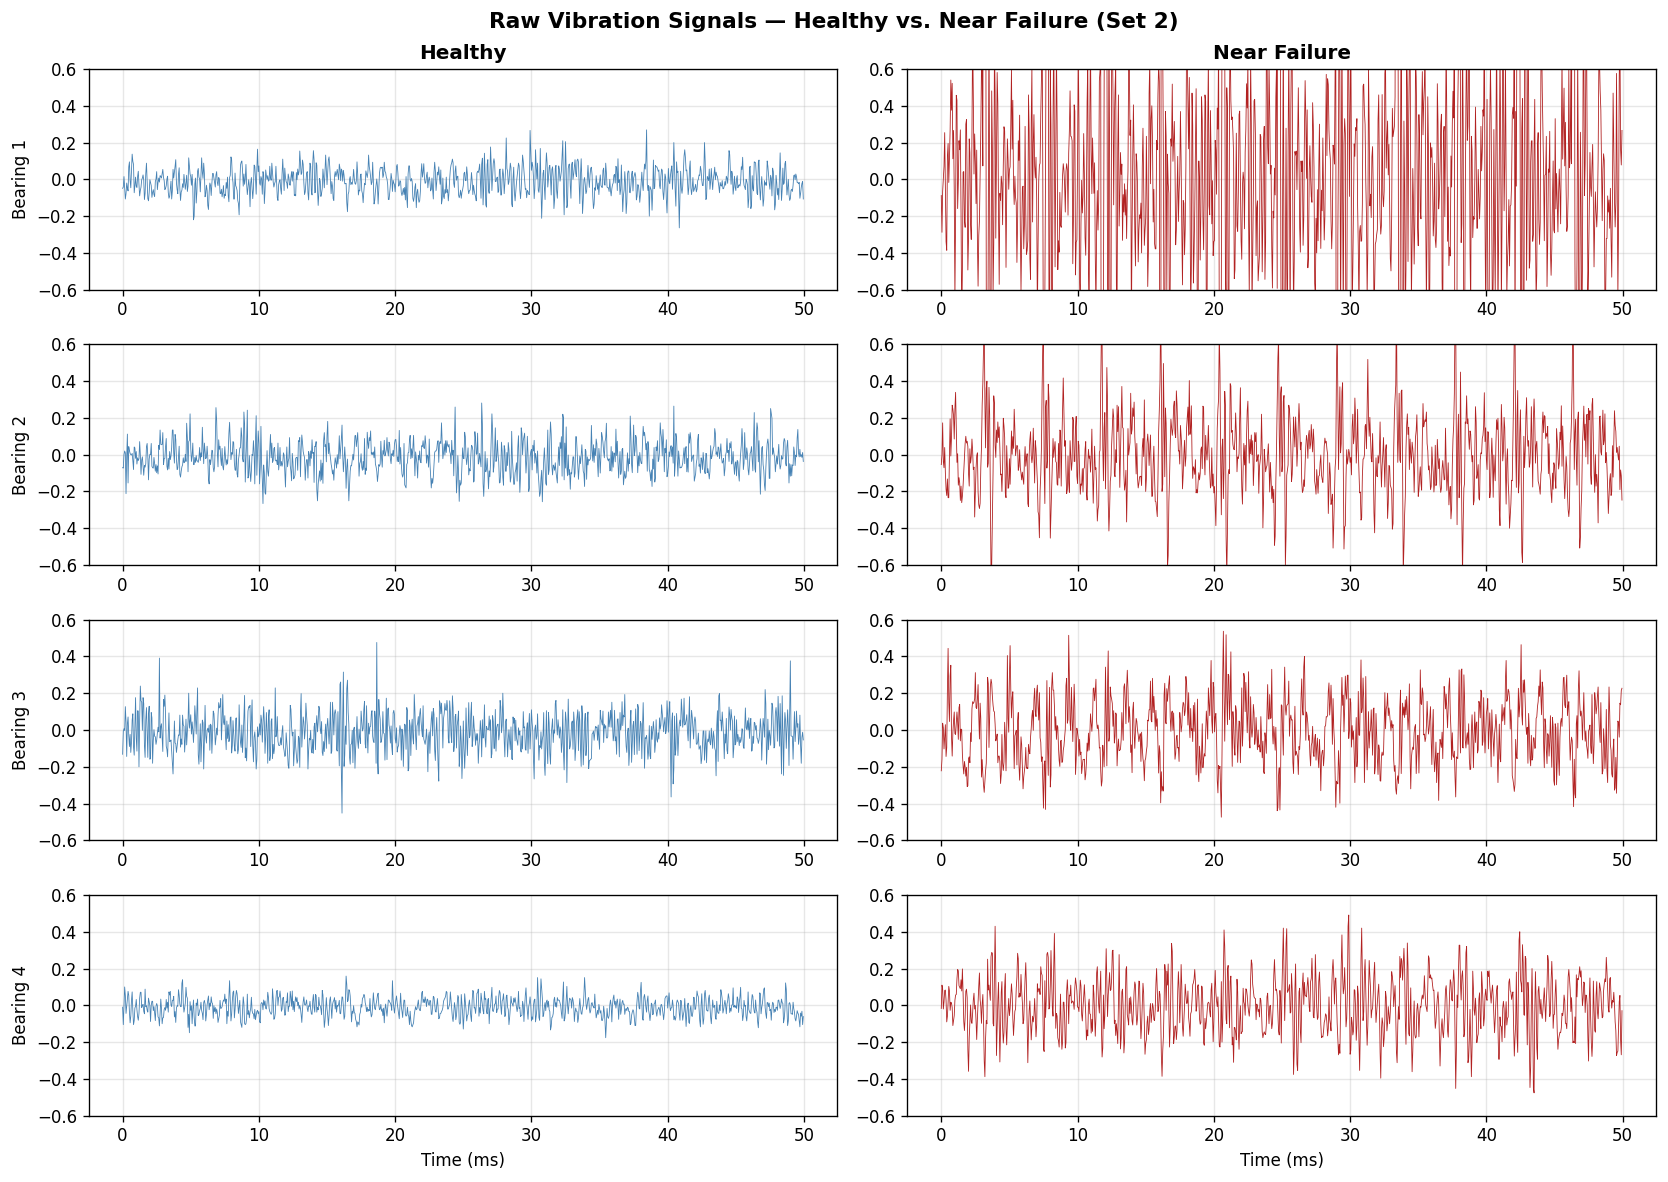

In [3]:
# =========================================================================
# Block 3b: Raw Vibration Signals — Healthy vs. Near Failure
# =========================================================================

fig, axes = plt.subplots(4, 2, figsize=(14, 10))
fig.suptitle('Raw Vibration Signals — Healthy vs. Near Failure (Set 2)', fontsize=13, fontweight='bold')

sample_points = 1000  # ~0.05 sec at 20kHz
time_axis = np.arange(sample_points) / SAMPLING_RATE * 1000  # milliseconds

for i in range(4):
    # Healthy
    axes[i, 0].plot(time_axis, raw_healthy[i][:sample_points], linewidth=0.5, color='steelblue')
    axes[i, 0].set_ylabel(f'Bearing {i+1}')
    axes[i, 0].set_ylim(-0.6, 0.6)
    axes[i, 0].grid(True, alpha=0.3)
    if i == 0:
        axes[i, 0].set_title('Healthy', fontweight='bold')

    # Near failure
    axes[i, 1].plot(time_axis, raw_failing[i][:sample_points], linewidth=0.5, color='firebrick')
    axes[i, 1].set_ylim(-0.6, 0.6)
    axes[i, 1].grid(True, alpha=0.3)
    if i == 0:
        axes[i, 1].set_title('Near Failure', fontweight='bold')

axes[3, 0].set_xlabel('Time (ms)')
axes[3, 1].set_xlabel('Time (ms)')
plt.tight_layout()
plt.show()

The difference is visible to the naked eye — the near-failure signals show higher amplitude and more erratic patterns, especially on Bearing 1. But visually inspecting time-domain waveforms doesn't scale. We need a more systematic way to characterize what's changing.

## 2. Frequency Domain Analysis

Vibration analysts don't typically stare at raw waveforms. Instead, they look at the **frequency spectrum** — a decomposition of the signal into its constituent frequencies using the Fast Fourier Transform (FFT).

Why? Because different types of bearing faults produce vibration energy at **characteristic frequencies**. A healthy bearing has clean, predictable peaks at harmonics of the shaft rotation frequency (33.3 Hz at 2000 RPM). A damaged bearing develops new peaks at fault-specific frequencies — for example, an outer race defect produces energy at the Ball Pass Frequency Outer (BPFO) and its harmonics.

Let's compare the frequency spectrum of Bearing 1 when healthy vs. near failure.

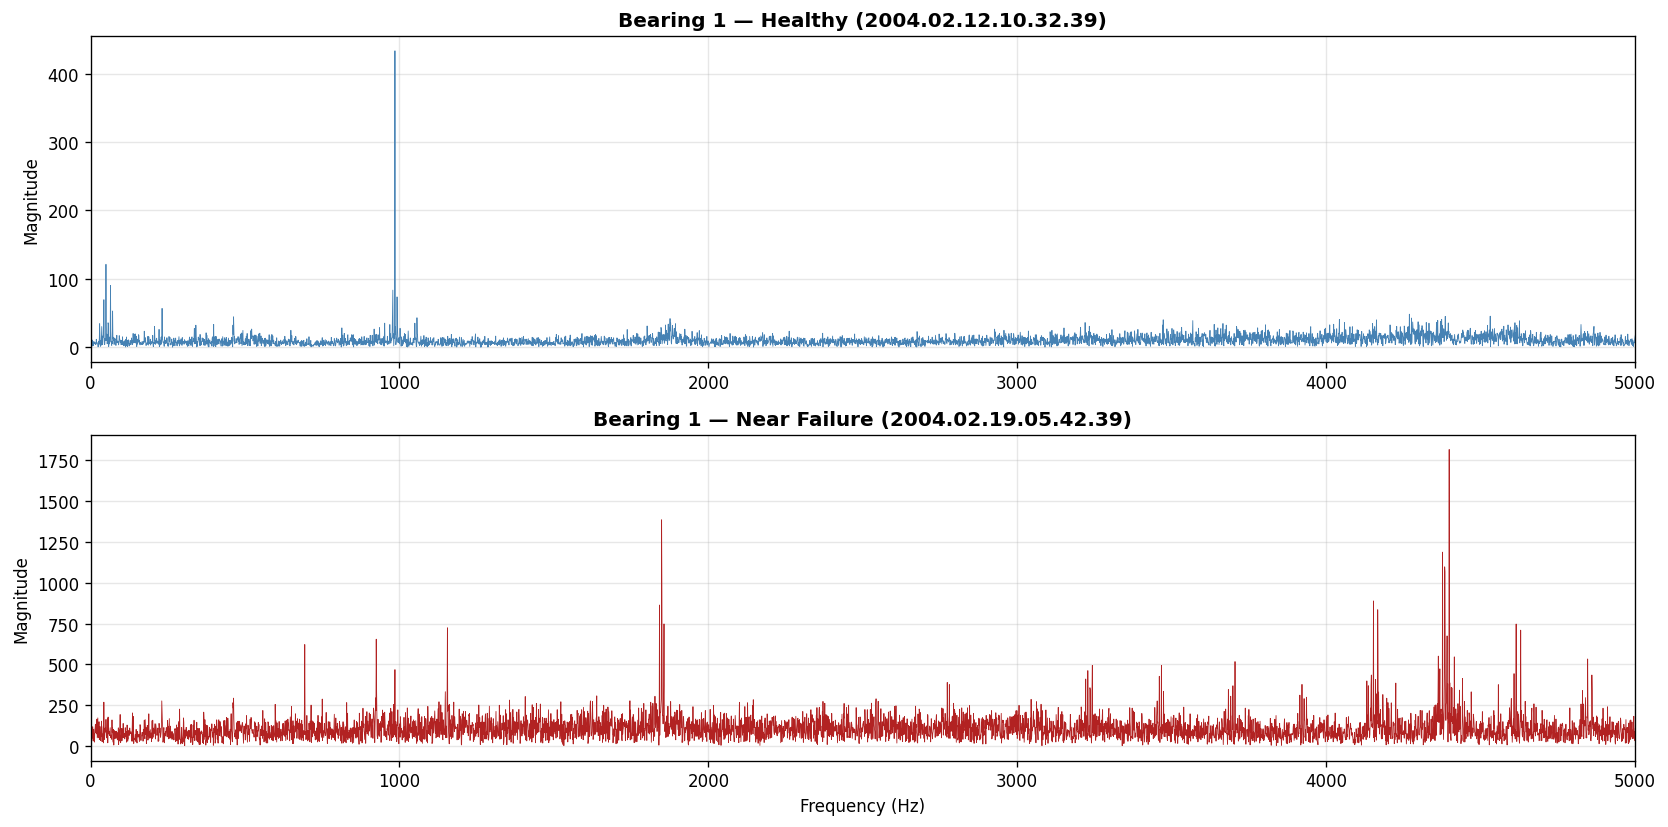

Peak magnitude — Healthy: 433.2
Peak magnitude — Failing: 1816.0


In [4]:
# =========================================================================
# Block 4: FFT — Healthy vs. Failing Frequency Spectra
# =========================================================================

def compute_fft(signal, sampling_rate):
    """Compute single-sided FFT magnitude spectrum."""
    N = len(signal)
    fft_values = fft(signal)
    fft_freq = fftfreq(N, 1 / sampling_rate)
    positive_mask = fft_freq > 0
    return fft_freq[positive_mask], np.abs(fft_values[positive_mask])

# Bearing 1 (fails in Set 2)
freq_healthy, mag_healthy = compute_fft(raw_healthy[0].values, SAMPLING_RATE)
freq_failing, mag_failing = compute_fft(raw_failing[0].values, SAMPLING_RATE)

fig, axes = plt.subplots(2, 1, figsize=(14, 7))

axes[0].plot(freq_healthy, mag_healthy, linewidth=0.5, color='steelblue')
axes[0].set_title(f'Bearing 1 — Healthy ({files_set2[0]})', fontweight='bold')
axes[0].set_ylabel('Magnitude')
axes[0].set_xlim(0, 5000)
axes[0].grid(True, alpha=0.3)

axes[1].plot(freq_failing, mag_failing, linewidth=0.5, color='firebrick')
axes[1].set_title(f'Bearing 1 — Near Failure ({files_set2[-5]})', fontweight='bold')
axes[1].set_ylabel('Magnitude')
axes[1].set_xlabel('Frequency (Hz)')
axes[1].set_xlim(0, 5000)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Peak magnitude — Healthy: {mag_healthy.max():.1f}")
print(f"Peak magnitude — Failing: {mag_failing.max():.1f}")

The spectra tell a clear story. The healthy bearing shows sharp, well-defined peaks — energy concentrated at specific frequencies related to the shaft rotation. The failing bearing shows dramatically higher amplitudes and new frequency components emerging, indicating structural damage generating additional vibration modes.

This confirms that both time-domain and frequency-domain information carry useful degradation signals. The next step is to systematically extract these signals into numerical features that a machine learning model can work with.

## 3. Feature Engineering

Raw vibration data (20,480 points per snapshot) is too high-dimensional for direct ML input. We need to compress each snapshot into a meaningful set of features that capture the bearing's health state.

We extract **14 features** per file, split across two domains:

**Time-domain features** capture the overall shape and intensity of the vibration signal:
- **RMS** — root mean square, the standard measure of vibration severity
- **Peak** and **Peak-to-Peak** — maximum amplitude, sensitive to impulsive faults
- **Crest Factor** — peak/RMS ratio, indicates how "spiky" the signal is
- **Kurtosis** — measures the "tailedness" of the distribution; healthy bearings have near-Gaussian vibration (kurtosis ~3), while early-stage faults produce impulsive signals with high kurtosis
- **Skewness** — asymmetry of the signal distribution
- **Mean Absolute Value** and **Standard Deviation** — general amplitude measures

**Frequency-domain features** capture how vibration energy is distributed across frequencies:
- **Dominant Frequency** — the frequency with highest energy
- **Spectral Centroid** — the "center of mass" of the spectrum; shifts as fault frequencies emerge
- **Spectral Spread** — bandwidth of the spectrum; broadens as damage progresses
- **Band Energies** (low/mid/high) — fraction of total energy in 0–1kHz, 1–5kHz, and 5–10kHz bands; fault progression often shifts energy between bands

We extract these features from the **failing bearing** in each of the three test sets.

In [5]:
# =========================================================================
# Block 5: Feature Extraction — Time & Frequency Domain
# =========================================================================

def extract_features(signal, sampling_rate=20000):
    """
    Extract time-domain and frequency-domain features from a vibration signal.
    
    Time-domain: RMS, peak, crest factor, kurtosis, skewness, peak-to-peak
    Frequency-domain: dominant frequency, spectral centroid, spectral spread,
                      band energies (low/mid/high)
    """
    # --- Time-domain features ---
    rms = np.sqrt(np.mean(signal ** 2))
    peak = np.max(np.abs(signal))
    crest_factor = peak / rms if rms > 0 else 0
    kurt = kurtosis(signal)
    skewness_val = skew(signal)
    peak_to_peak = np.max(signal) - np.min(signal)
    mean_abs = np.mean(np.abs(signal))
    std = np.std(signal)
    
    # --- Frequency-domain features ---
    N = len(signal)
    fft_values = fft(signal)
    fft_freq = fftfreq(N, 1 / sampling_rate)
    positive_mask = fft_freq > 0
    freq = fft_freq[positive_mask]
    magnitude = np.abs(fft_values[positive_mask])
    
    # Dominant frequency
    dominant_freq = freq[np.argmax(magnitude)]
    
    # Spectral centroid (center of mass of spectrum)
    mag_sum = np.sum(magnitude)
    spectral_centroid = np.sum(freq * magnitude) / mag_sum if mag_sum > 0 else 0
    
    # Spectral spread (bandwidth)
    spectral_spread = np.sqrt(
        np.sum(((freq - spectral_centroid) ** 2) * magnitude) / mag_sum
    ) if mag_sum > 0 else 0
    
    # Band energies (fraction of total energy in each band)
    total_energy = np.sum(magnitude ** 2)
    if total_energy > 0:
        low_band = np.sum(magnitude[(freq >= 0) & (freq < 1000)] ** 2) / total_energy
        mid_band = np.sum(magnitude[(freq >= 1000) & (freq < 5000)] ** 2) / total_energy
        high_band = np.sum(magnitude[(freq >= 5000)] ** 2) / total_energy
    else:
        low_band = mid_band = high_band = 0
    
    return {
        'rms': rms,
        'peak': peak,
        'crest_factor': crest_factor,
        'kurtosis': kurt,
        'skewness': skewness_val,
        'peak_to_peak': peak_to_peak,
        'mean_abs': mean_abs,
        'std': std,
        'dominant_freq': dominant_freq,
        'spectral_centroid': spectral_centroid,
        'spectral_spread': spectral_spread,
        'energy_low': low_band,
        'energy_mid': mid_band,
        'energy_high': high_band,
    }


def extract_all_features(data_dir, bearing_idx, sampling_rate=20000):
    """
    Extract features from every file in a dataset for a specific bearing.
    Returns DataFrame with features indexed by timestamp.
    """
    files = sorted(os.listdir(data_dir))
    rows = []
    timestamps = []
    
    for filename in files:
        filepath = os.path.join(data_dir, filename)
        raw = pd.read_csv(filepath, sep='\t', header=None)
        signal = raw[bearing_idx].values
        feats = extract_features(signal, sampling_rate)
        rows.append(feats)
        try:
            ts = pd.to_datetime(filename, format='%Y.%m.%d.%H.%M.%S')
        except:
            ts = filename
        timestamps.append(ts)
    
    df = pd.DataFrame(rows, index=timestamps)
    df.index.name = 'timestamp'
    return df


# Extract features for the failing bearing in each test set
print("Extracting features... (this may take a few minutes)")

features_set1 = extract_all_features(DATA_PATHS['set1'], bearing_idx=2)  # Bearing 3
print(f"Set 1 (Bearing 3 — inner race): {features_set1.shape}")

features_set2 = extract_all_features(DATA_PATHS['set2'], bearing_idx=0)  # Bearing 1
print(f"Set 2 (Bearing 1 — outer race): {features_set2.shape}")

features_set3 = extract_all_features(DATA_PATHS['set3'], bearing_idx=2)  # Bearing 3
print(f"Set 3 (Bearing 3 — outer race): {features_set3.shape}")

print(f"\nFeatures extracted: {list(features_set2.columns)}")

Extracting features... (this may take a few minutes)
Set 1 (Bearing 3 — inner race): (2156, 14)
Set 2 (Bearing 1 — outer race): (984, 14)
Set 3 (Bearing 3 — outer race): (6324, 14)

Features extracted: ['rms', 'peak', 'crest_factor', 'kurtosis', 'skewness', 'peak_to_peak', 'mean_abs', 'std', 'dominant_freq', 'spectral_centroid', 'spectral_spread', 'energy_low', 'energy_mid', 'energy_high']


## 4. How Do These Features Change as Bearings Degrade?

With features extracted for every 10-minute snapshot across the full lifetime of each bearing, we can now visualize the degradation process. The plots below show how each feature evolves from healthy (0%) to failure (100%) across all three test sets.

This is important for two reasons: it confirms that our features actually capture degradation, and it reveals which features are most informative — useful knowledge when interpreting model results later.

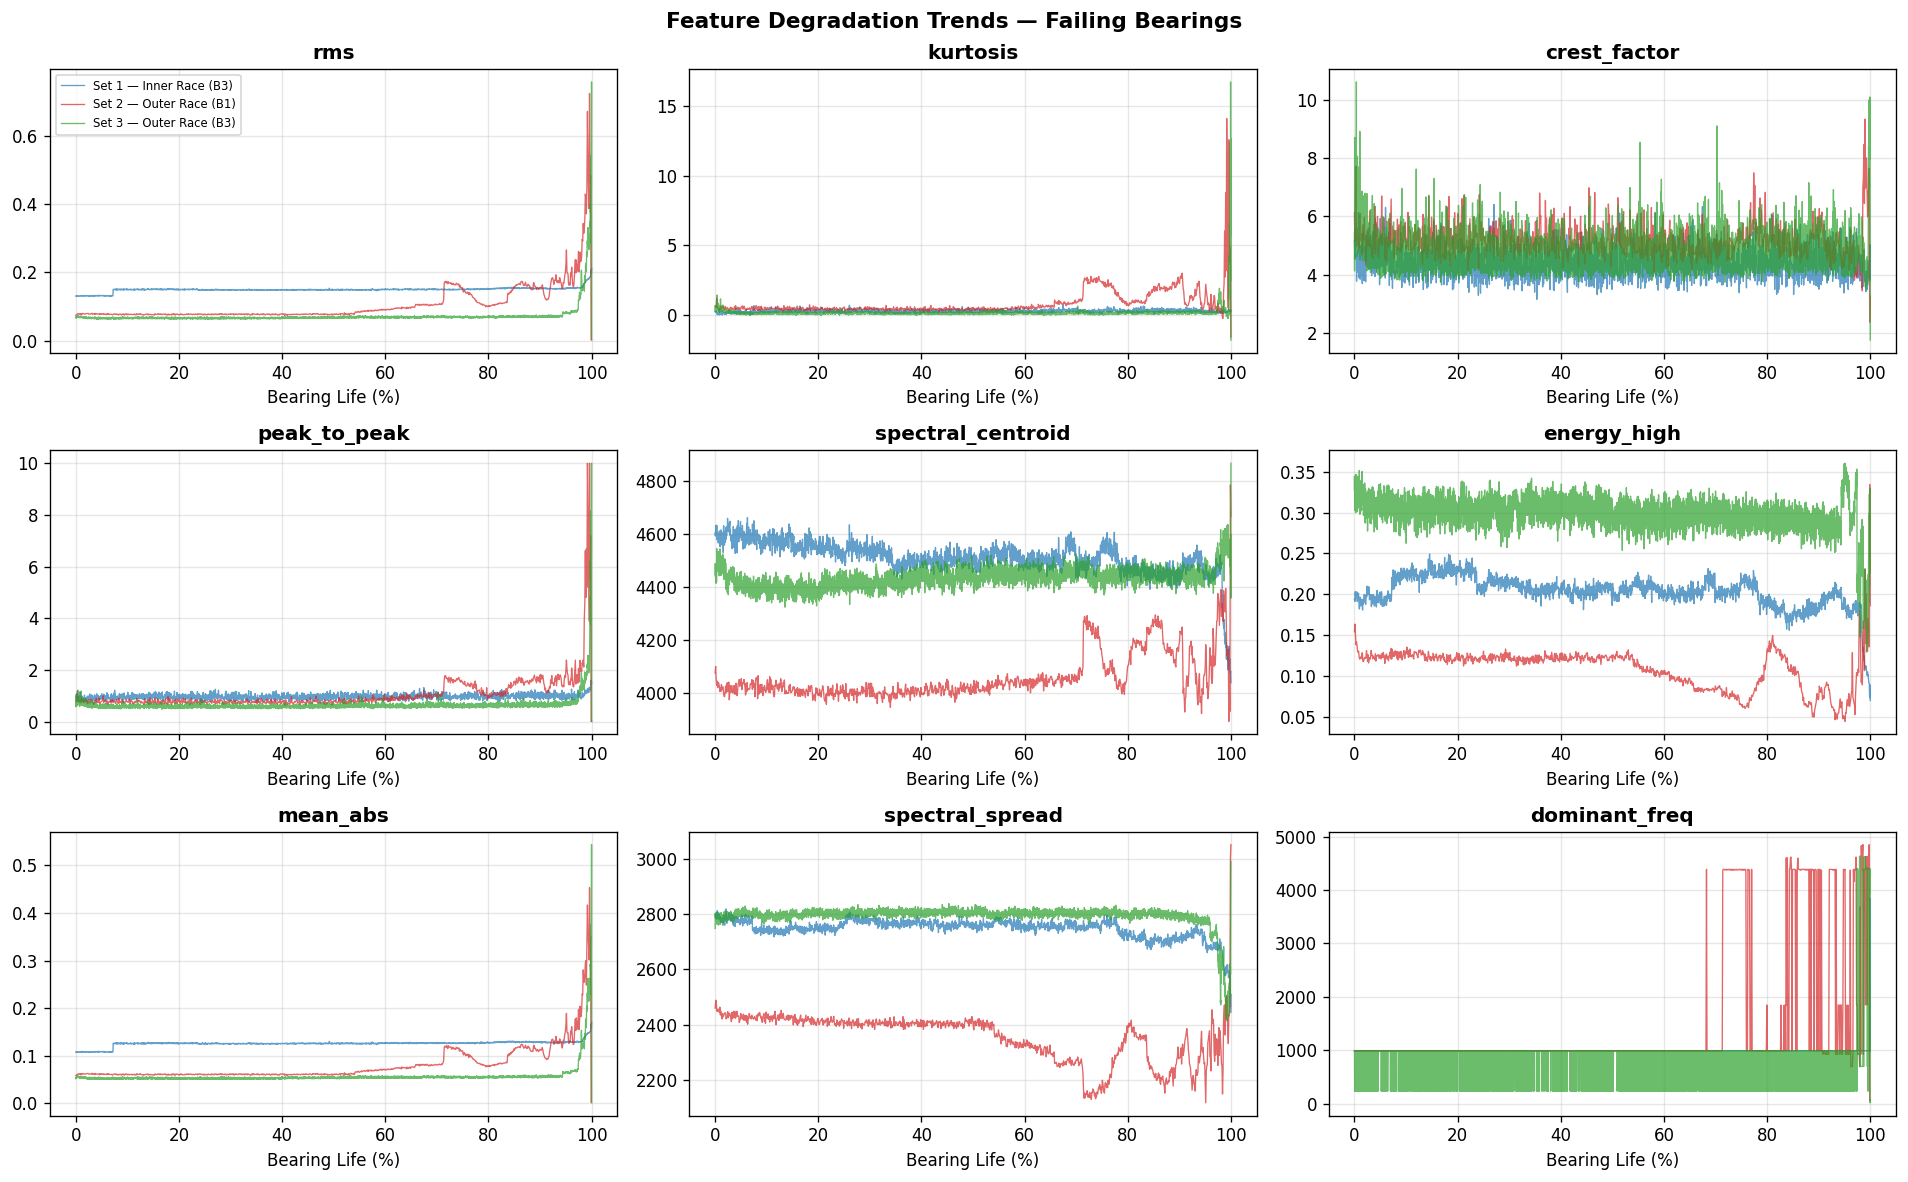

Key observations:
- RMS and mean_abs increase dramatically near end of life
- Kurtosis often spikes early in degradation (impulsive fault signals)
- Spectral features shift as fault frequencies emerge


In [6]:
# =========================================================================
# Block 6: Degradation Trends Across Key Features
# =========================================================================

fig, axes = plt.subplots(3, 3, figsize=(16, 10))
fig.suptitle('Feature Degradation Trends — Failing Bearings', fontsize=13, fontweight='bold')

plot_features = ['rms', 'kurtosis', 'crest_factor', 'peak_to_peak', 'spectral_centroid',
                 'energy_high', 'mean_abs', 'spectral_spread', 'dominant_freq']

sets_data = [
    (features_set1, 'Set 1 — Inner Race (B3)', 'tab:blue'),
    (features_set2, 'Set 2 — Outer Race (B1)', 'tab:red'),
    (features_set3, 'Set 3 — Outer Race (B3)', 'tab:green'),
]

for idx, feat in enumerate(plot_features):
    ax = axes[idx // 3, idx % 3]
    for df, label, color in sets_data:
        life_pct = np.linspace(0, 100, len(df))
        ax.plot(life_pct, df[feat], linewidth=0.8, label=label, color=color, alpha=0.7)
    ax.set_title(feat, fontweight='bold')
    ax.set_xlabel('Bearing Life (%)')
    ax.grid(True, alpha=0.3)

axes[0, 0].legend(fontsize=7, loc='upper left')
plt.tight_layout()
plt.show()

print("Key observations:")
print("- RMS and mean_abs increase dramatically near end of life")
print("- Kurtosis often spikes early in degradation (impulsive fault signals)")
print("- Spectral features shift as fault frequencies emerge")

Several patterns are worth noting. RMS and mean absolute vibration remain flat throughout healthy operation and then spike sharply near failure — these are reliable late-stage indicators. Kurtosis, on the other hand, often shows early spikes before the amplitude-based features react, making it a useful early warning signal. The spectral features (centroid, spread, band energies) shift as fault-related frequency components emerge and grow.

Different failure types also show different degradation signatures — the inner race failure (blue) and outer race failures (red, green) follow distinct trajectories. This suggests that a classifier should be able to distinguish between fault types.

## 5. Anomaly Detection — Can We Detect That Something Is Wrong?

The first task in a predictive maintenance system is **anomaly detection**: given a baseline of healthy operation, flag when the bearing's behavior deviates from normal.

We'll demonstrate two approaches using Set 2, where we know Bearing 1 fails with an outer race defect. We split the data 70/30 — the first 70% serves as the "healthy baseline" for training, and we evaluate detection on the remaining 30%.

### Approach 1: Simple Threshold

The simplest method: compute the mean and standard deviation of RMS vibration during healthy operation, then flag anything above mean + 3σ as anomalous. This is essentially a statistical control chart — the same approach used in many industrial monitoring systems.

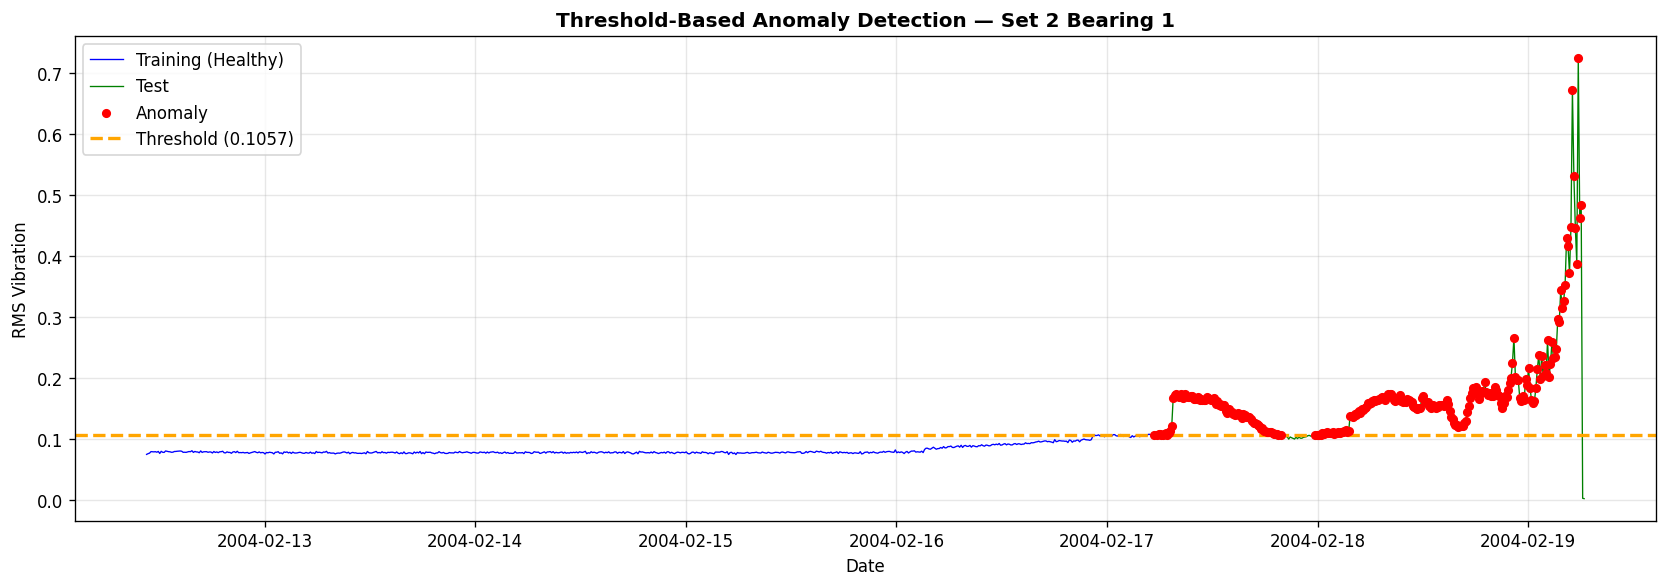

Threshold: 0.10568
Anomalies in test set: 269 / 296 (90.9%)
First anomaly: 2004-02-17 05:22:39
Last timestamp: 2004-02-19 06:22:39
Advance warning: 2 days 01:00:00


In [7]:
# =========================================================================
# Block 7: Threshold-Based Anomaly Detection (Set 2)
# =========================================================================

split_idx = int(len(features_set2) * 0.7)
train_feats = features_set2.iloc[:split_idx]
test_feats = features_set2.iloc[split_idx:]

# Threshold: mean + 3*std on RMS
rms_mean = train_feats['rms'].mean()
rms_std = train_feats['rms'].std()
threshold = rms_mean + 3 * rms_std

anomalies = test_feats['rms'] > threshold

fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(train_feats.index, train_feats['rms'], 'b-', linewidth=0.8, label='Training (Healthy)')
ax.plot(test_feats.index, test_feats['rms'], 'g-', linewidth=0.8, label='Test')
ax.scatter(test_feats[anomalies].index, test_feats[anomalies]['rms'],
           color='red', s=20, zorder=5, label='Anomaly')
ax.axhline(y=threshold, color='orange', linestyle='--', linewidth=2,
           label=f'Threshold ({threshold:.4f})')
ax.set_xlabel('Date')
ax.set_ylabel('RMS Vibration')
ax.set_title('Threshold-Based Anomaly Detection — Set 2 Bearing 1', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

first_anomaly = test_feats[anomalies].index[0] if anomalies.any() else None
print(f"Threshold: {threshold:.5f}")
print(f"Anomalies in test set: {anomalies.sum()} / {len(test_feats)} ({anomalies.mean()*100:.1f}%)")
print(f"First anomaly: {first_anomaly}")
print(f"Last timestamp: {test_feats.index[-1]}")
if first_anomaly:
    print(f"Advance warning: {test_feats.index[-1] - first_anomaly}")

The threshold approach works — it catches the degradation and provides roughly 2 days of advance warning. But it has a fundamental limitation: it only looks at one feature (RMS) in isolation. A bearing could be degrading in ways that show up in frequency-domain features before RMS increases.

### Approach 2: Isolation Forest (Multivariate)

Isolation Forest is an unsupervised anomaly detection algorithm that works by randomly partitioning the feature space. The key insight is that anomalies — being rare and different — are easier to isolate (require fewer random splits) than normal points.

By training Isolation Forest on all 14 features from the healthy period, we can detect multivariate anomalies — cases where the *combination* of features is unusual, even if no single feature has crossed a threshold.

We also define a tiered alert system based on anomaly score severity:
- **Normal**: Score ≥ 0 (within healthy distribution)
- **Warning**: Score < 0 (deviating from normal)
- **Alert**: Score < -0.10 (significant deviation)
- **Critical**: Score < -0.15 (severe anomaly, likely imminent failure)

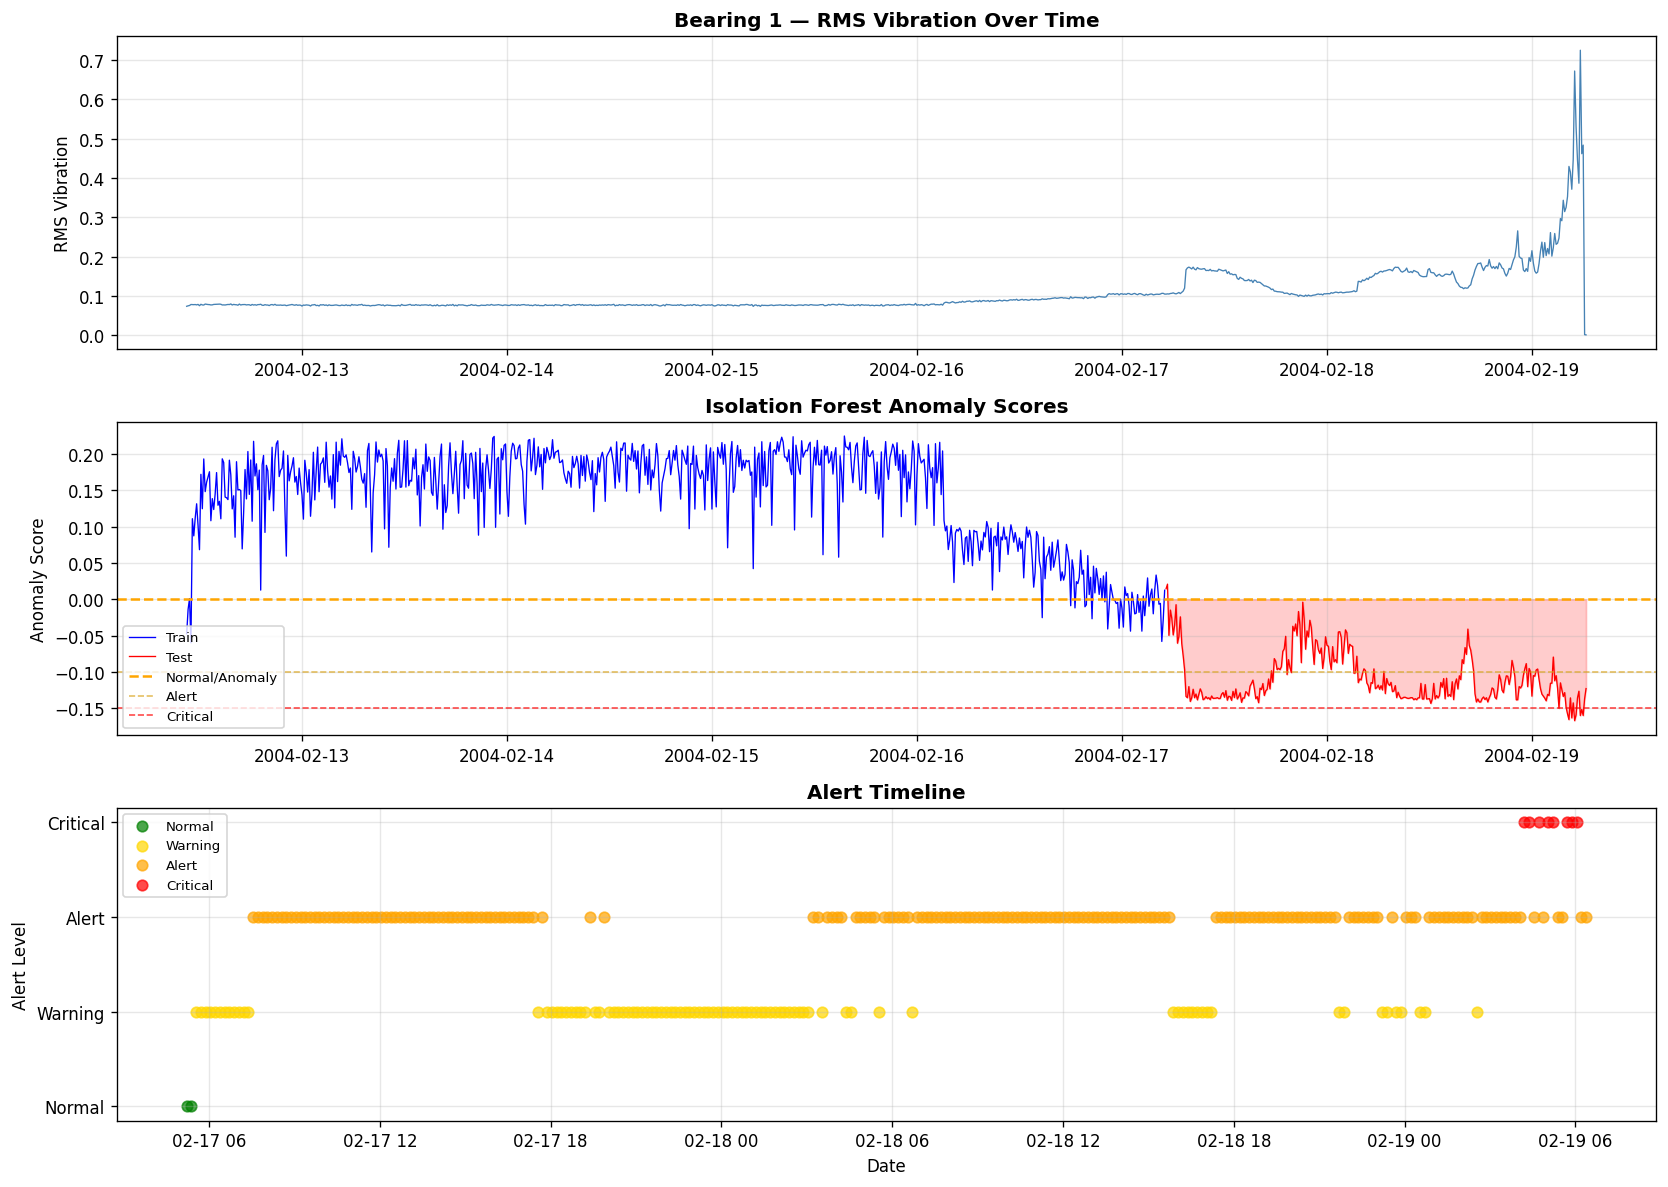

ANOMALY DETECTION SUMMARY — Set 2
Training anomalies: 35 / 688
Test anomalies:     294 / 296

Severity breakdown (test set):
  Normal    : 2
  Alert     : 196
  Critical  : 8

First warning:   2004-02-17 05:32:39
Failure time:    2004-02-19 06:22:39
Advance warning: 2 days 00:50:00


In [8]:
# =========================================================================
# Block 8: Isolation Forest with Engineered Features
# =========================================================================

# Standardize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(train_feats)
X_test_scaled = scaler.transform(test_feats)

# Train on healthy data
iso_forest = IsolationForest(contamination=0.05, random_state=42, n_estimators=200)
iso_forest.fit(X_train_scaled)

train_pred = iso_forest.predict(X_train_scaled)
test_pred = iso_forest.predict(X_test_scaled)
train_scores = iso_forest.decision_function(X_train_scaled)
test_scores = iso_forest.decision_function(X_test_scaled)

# Severity levels
def assign_severity(scores):
    severity = np.full(len(scores), 'Normal', dtype=object)
    severity[scores < 0] = 'Warning'
    severity[scores < -0.10] = 'Alert'
    severity[scores < -0.15] = 'Critical'
    return severity

test_severity = assign_severity(test_scores)

# --- Visualization ---
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# Panel 1: RMS vibration
axes[0].plot(features_set2.index, features_set2['rms'], color='steelblue', linewidth=0.8)
axes[0].set_ylabel('RMS Vibration')
axes[0].set_title('Bearing 1 — RMS Vibration Over Time', fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Panel 2: Anomaly scores
axes[1].plot(train_feats.index, train_scores, 'b-', linewidth=0.8, label='Train')
axes[1].plot(test_feats.index, test_scores, 'r-', linewidth=0.8, label='Test')
axes[1].axhline(y=0, color='orange', linestyle='--', linewidth=1.5, label='Normal/Anomaly')
axes[1].axhline(y=-0.10, color='goldenrod', linestyle='--', linewidth=1, alpha=0.7, label='Alert')
axes[1].axhline(y=-0.15, color='red', linestyle='--', linewidth=1, alpha=0.7, label='Critical')
axes[1].fill_between(test_feats.index, test_scores, 0,
                      where=(test_scores < 0), alpha=0.2, color='red')
axes[1].set_ylabel('Anomaly Score')
axes[1].set_title('Isolation Forest Anomaly Scores', fontweight='bold')
axes[1].legend(loc='lower left', fontsize=8)
axes[1].grid(True, alpha=0.3)

# Panel 3: Alert timeline
colors_map = {'Normal': 'green', 'Warning': 'gold', 'Alert': 'orange', 'Critical': 'red'}
level_order = ['Normal', 'Warning', 'Alert', 'Critical']
for level in level_order:
    mask = test_severity == level
    if mask.any():
        y_pos = level_order.index(level)
        axes[2].scatter(test_feats.index[mask], [y_pos] * mask.sum(),
                       c=colors_map[level], s=40, label=level, alpha=0.7)
axes[2].set_yticks(range(4))
axes[2].set_yticklabels(level_order)
axes[2].set_ylabel('Alert Level')
axes[2].set_xlabel('Date')
axes[2].set_title('Alert Timeline', fontweight='bold')
axes[2].legend(loc='upper left', fontsize=8)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary
print("=" * 60)
print("ANOMALY DETECTION SUMMARY — Set 2")
print("=" * 60)
print(f"Training anomalies: {(train_pred == -1).sum()} / {len(train_pred)}")
print(f"Test anomalies:     {(test_pred == -1).sum()} / {len(test_pred)}")
print(f"\nSeverity breakdown (test set):")
for level in level_order:
    count = (test_severity == level).sum()
    print(f"  {level:10s}: {count}")

warning_idx = np.where(test_severity != 'Normal')[0]
if len(warning_idx) > 0:
    first_warning = test_feats.index[warning_idx[0]]
    failure_time = test_feats.index[-1]
    print(f"\nFirst warning:   {first_warning}")
    print(f"Failure time:    {failure_time}")
    print(f"Advance warning: {failure_time - first_warning}")
print("=" * 60)

The Isolation Forest approach provides roughly 2 days of advance warning with a graduated severity scale. In a real deployment, a maintenance team would see the Warning → Alert → Critical progression and could schedule an inspection or bearing replacement during a planned downtime window rather than dealing with a surprise failure.

Anomaly detection answers the question *"is something wrong?"* — but it doesn't tell us *what* is wrong. For that, we need classification.

## 6. Fault Classification — What Type of Failure Is Developing?

Knowing that a bearing is degrading is useful. Knowing *how* it's degrading is even more useful — different fault types may require different repair strategies, parts, or urgency levels.

We have three test sets with two known failure modes: inner race defect (Set 1) and outer race defect (Sets 2 and 3). This gives us a three-class classification problem: **normal**, **inner race**, and **outer race**.

### Labeling Strategy

The IMS dataset doesn't provide per-sample labels — we only know *which* bearing failed and *what type* of failure occurred. To create training labels, we use the bearing's position in its lifecycle:

- **First 70%** of each run → labeled as **normal** (healthy operation)
- **Middle 15%** → **discarded** (transition period where the label is ambiguous)
- **Last 15%** → labeled with the **known fault type**

We also add the full run of a non-failing bearing (Set 2, Bearing 2) as additional normal samples.

This is a common approach for run-to-failure datasets where explicit fault labels aren't available. In a production system, maintenance logs or expert annotations would provide more precise labels.

In [9]:
# =========================================================================
# Block 9a: Label Data for Classification
# =========================================================================

def label_dataset(features_df, fault_type, healthy_pct=0.70, discard_pct=0.15):
    """
    Label a feature DataFrame based on position in bearing lifecycle.
    First healthy_pct = 'normal', middle discard_pct = dropped, rest = fault_type.
    """
    n = len(features_df)
    healthy_end = int(n * healthy_pct)
    fault_start = int(n * (healthy_pct + discard_pct))
    
    healthy = features_df.iloc[:healthy_end].copy()
    healthy['label'] = 'normal'
    
    faulty = features_df.iloc[fault_start:].copy()
    faulty['label'] = fault_type
    
    return pd.concat([healthy, faulty])

# Also extract features for a healthy bearing (non-failing) for extra normal samples
print("Extracting features for healthy bearing (Set 2, Bearing 2)...")
healthy_set2_b2 = extract_all_features(DATA_PATHS['set2'], bearing_idx=1)
healthy_set2_b2_labeled = healthy_set2_b2.copy()
healthy_set2_b2_labeled['label'] = 'normal'

# Label each dataset
labeled_set1 = label_dataset(features_set1, 'inner_race')
labeled_set2 = label_dataset(features_set2, 'outer_race')
labeled_set3 = label_dataset(features_set3, 'outer_race')

# Combine and shuffle
all_labeled = pd.concat([labeled_set1, labeled_set2, labeled_set3, healthy_set2_b2_labeled])
all_labeled = all_labeled.sample(frac=1, random_state=42)

feature_cols = [c for c in all_labeled.columns if c != 'label']
X = all_labeled[feature_cols].values
y = all_labeled['label'].values

print(f"\nDataset shape: {X.shape}")
print(f"\nClass distribution:")
for cls in np.unique(y):
    print(f"  {cls:12s}: {(y == cls).sum()} samples")

# Standardize
scaler_clf = StandardScaler()
X_scaled = scaler_clf.fit_transform(X)

Extracting features for healthy bearing (Set 2, Bearing 2)...

Dataset shape: (9028, 14)

Class distribution:
  inner_race  : 324 samples
  normal      : 7607 samples
  outer_race  : 1097 samples


The class distribution is imbalanced — normal samples heavily outnumber fault samples, which reflects reality (bearings spend most of their life in a healthy state). We use stratified cross-validation to ensure each fold has representative proportions of all classes.

We evaluate two ensemble methods: **Random Forest** and **Gradient Boosting**. Both are strong choices for tabular data with relatively few features, and both provide feature importance scores that help us understand what the model is learning.

5-Fold Cross-Validation Results:
---------------------------------------------
Random Forest            : 0.9818 ± 0.0037
Gradient Boosting        : 0.9824 ± 0.0031

Best model: Gradient Boosting (0.9824)

Classification Report (Gradient Boosting):
              precision    recall  f1-score   support

  inner_race      0.994     0.972     0.983       324
      normal      0.988     0.991     0.990      7607
  outer_race      0.939     0.923     0.931      1097

    accuracy                          0.982      9028
   macro avg      0.974     0.962     0.968      9028
weighted avg      0.982     0.982     0.982      9028



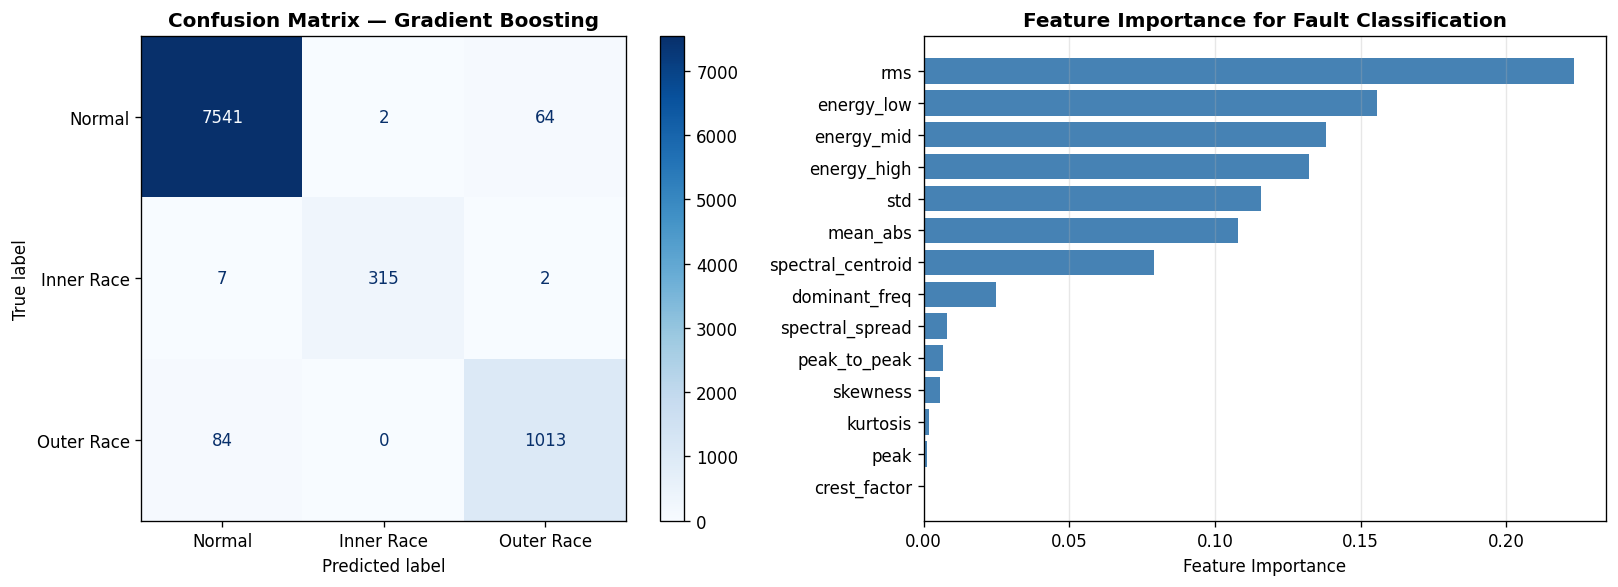


Overall Accuracy: 98.2%


In [10]:
# =========================================================================
# Block 9b: Train & Evaluate Classifiers
# =========================================================================

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

models = {
    'Random Forest': RandomForestClassifier(n_estimators=200, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=200, random_state=42),
}

print("5-Fold Cross-Validation Results:")
print("-" * 45)
best_score = 0
best_name = None

for name, model in models.items():
    scores = cross_val_score(model, X_scaled, y, cv=cv, scoring='accuracy')
    print(f"{name:25s}: {scores.mean():.4f} \u00b1 {scores.std():.4f}")
    if scores.mean() > best_score:
        best_score = scores.mean()
        best_name = name

print(f"\nBest model: {best_name} ({best_score:.4f})")

# Full training + cross-validated predictions
best_model = models[best_name]
best_model.fit(X_scaled, y)
y_pred_cv = cross_val_predict(best_model, X_scaled, y, cv=cv)

print(f"\nClassification Report ({best_name}):")
print(classification_report(y, y_pred_cv, digits=3))

# --- Confusion Matrix & Feature Importance ---
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

cm = confusion_matrix(y, y_pred_cv, labels=['normal', 'inner_race', 'outer_race'])
disp = ConfusionMatrixDisplay(cm, display_labels=['Normal', 'Inner Race', 'Outer Race'])
disp.plot(ax=axes[0], cmap='Blues', values_format='d')
axes[0].set_title(f'Confusion Matrix — {best_name}', fontweight='bold')

if hasattr(best_model, 'feature_importances_'):
    importances = best_model.feature_importances_
    sorted_idx = np.argsort(importances)
    axes[1].barh(range(len(sorted_idx)), importances[sorted_idx], color='steelblue')
    axes[1].set_yticks(range(len(sorted_idx)))
    axes[1].set_yticklabels(np.array(feature_cols)[sorted_idx])
    axes[1].set_xlabel('Feature Importance')
    axes[1].set_title('Feature Importance for Fault Classification', fontweight='bold')
    axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

accuracy = accuracy_score(y, y_pred_cv)
print(f"\nOverall Accuracy: {accuracy*100:.1f}%")

## Results Summary

### Anomaly Detection

Both approaches successfully detected bearing degradation with approximately **2 days of advance warning** before failure. The threshold method is simple and interpretable — it works well as a baseline. The Isolation Forest approach adds value by considering all 14 features simultaneously and providing a continuous anomaly score rather than a binary flag, enabling the tiered alert system (Warning → Alert → Critical) that would give maintenance teams graduated urgency signals.

### Fault Classification

The Gradient Boosting classifier achieved **98.2% overall accuracy** across three classes (normal, inner race defect, outer race defect) using 5-fold stratified cross-validation. Per-class performance was strong: inner race defects were identified with 0.983 F1-score, normal operation with 0.990, and outer race defects with 0.931.

The feature importance plot reveals that **RMS** is the dominant feature for classification, followed by band energy ratios and standard deviation — consistent with domain knowledge from vibration analysis. The combination of time-domain and frequency-domain features outperforms either domain alone.

### Practical Implications

Together, the anomaly detection and classification components form a two-stage diagnostic system. The anomaly detector answers *"is something wrong?"* — flagging deviations from healthy behavior. The classifier then answers *"what is wrong?"* — identifying the specific fault type to guide repair decisions. In a production deployment, these would be integrated into a monitoring dashboard, providing maintenance teams with both early warnings and diagnostic context to plan interventions during scheduled downtime rather than reacting to unexpected failures.

### Limitations & Future Work

- **Labeling**: Since the IMS dataset lacks per-sample annotations, we used timeline position as a proxy for labels. In production, maintenance logs or expert annotations would provide more precise ground truth.
- **Generalization**: The model was trained and evaluated on data from a single test rig. Real-world deployment would require validation across different equipment, operating conditions, and bearing types.
- **Additional fault types**: The IMS dataset only covers inner race and outer race defects. Roller element defects, cage failures, and lubrication issues would require additional training data.

### Tools Used
Python, NumPy, Pandas, Scikit-learn, SciPy, Matplotlib